# Final Project Data Analytics and IoT
## GeoLife Trajectories

In [1]:
import os
import random
import numpy as np
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
from tensorflow import keras
import matplotlib.pyplot as plt
import scikitplot
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import Image

from data_cleaning.add_labels import add_labels
from data_cleaning.prepare_data import prepare_data
from data_cleaning.clean_data import create_sequences
import training_models.lstm_time_series as lstm_time_series
import training_models.transformer_classifier as transformer_classifier
from data_presentation.plot_model_history import plot_model_history
from data_presentation.generate_tableau_csv import generate_tableau_csv

## Data Exploration
This code reads GPS data from a randomly chosen .plt file in a specified directory, converts the latitude and longitude coordinates into Point objects, and creates a geopandas DataFrame to represent the data. The resulting DataFrame is then plotted on a map using the plot() method of the geopandas DataFrame.

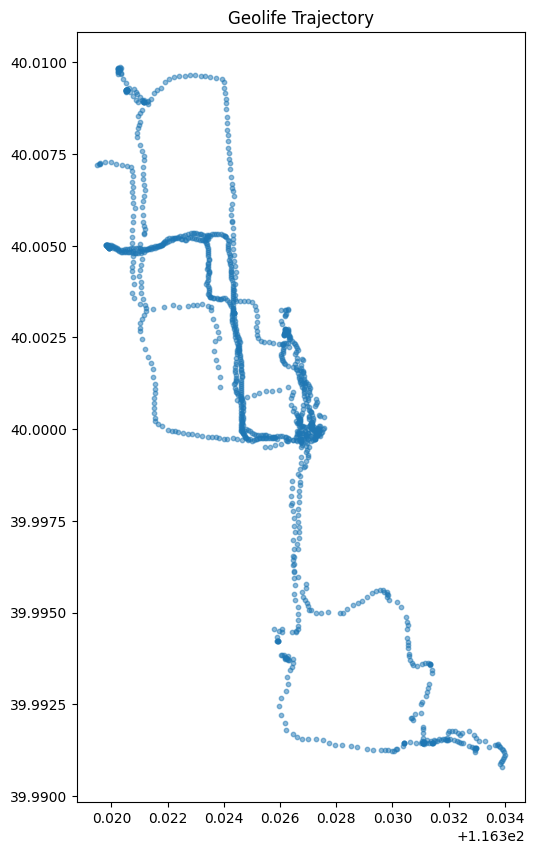

In [18]:
# Set the directory where the PLT files are located
dir_path = 'data/000/Trajectory'

# Get a list of all the PLT files in the directory
file_list = [f for f in os.listdir(dir_path) if f.endswith('.plt')]

# Choose a random PLT file from the list
plt_file = random.choice(file_list)

# Read the data from the PLT file
with open(os.path.join(dir_path, plt_file), 'r') as f:
    data = f.readlines()[6:]
data = [line.strip().split(',')[:6] for line in data]

# Create a pandas DataFrame and convert the latitude and longitude columns into Point objects
df = pd.DataFrame(data, columns=['lat', 'lon', 'alt', 'num_days', 'date', 'time'])
geometry = [Point(xy) for xy in zip(df.lon.astype(float), df.lat.astype(float))]

# Create a geopandas DataFrame using the pandas DataFrame and the Point objects
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Plot the data
ax = gdf.plot(figsize=(10, 10), alpha=0.5, markersize=10)
ax.set_title('Geolife Trajectory')
plt.savefig('results/data_exploration.png')

## Data Preparation
Create a pandas dataframe with every data point that has a label. 
This helper function code reads multiple GPS trajectory files from 181 folders, converts the altitude column from feet to meters, merges all dataframes into a single dataframe, and adds a label column to the dataframe based on the transportation mode mentioned in the corresponding text file (if available). The label addition function 'add_labels()' creates a list of dataframes, loops over each folder, checks if there is a text file present, and if so, it loads the text file into a dataframe, converts the start and end time columns into datetime format, and adds the label to the main dataframe by comparing it with the time column of the dataframe using the 'is_between()' function. Finally, the labeled dataframe is saved as a pickle file named 'df_labels.pkl'. (This process will take a long time due huge amount of data being processesd)

In [4]:
# add_labels()

## Data Cleaning
Because of the way the data was collected, there are some discontinuous entries. Randomly large time gaps exist, as well as adjacent points that have different labels.

Also, we need to prepare the data for the model training.

In this step, we divide the data into sequences of 100 points. Each sequence will have smaller time-steps between points, and will have only one label.

We also converted the latitude and longitude into x, y, and z coordinates for easier deep learning training, and calculated the distance between subsequent point, for velocity information.

We save the resulting arrays for easier testing.

Uncomment and run to create.

In [5]:
# sequence_data, label_array = create_sequences()
# with open('seq_labels.npz', 'wb') as f:
#     np.savez(f, sequence_data, label_array)

## Prepare data for training
Split data into train and test sets, scale using min-max scalar

In [6]:
x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm, _, _ = prepare_data('lstm')
input_shape_lstm = x_train_lstm.shape[1:]
output_shape_lstm = y_train_lstm.shape[1:][0]

x_train_transformer, \
    y_train_transformer, \
    x_test_transformer, \
    y_test_transformer, _, num_classes = prepare_data('transformer')
input_shape_transformer = x_train_transformer.shape[1:]

## Build the time series Model use LSTM
Model Building: Create a multi-layer LSTM network using the extracted features and normalized values as input. The output layer should have as many nodes as the number of features you want to predict (in this case, 3).

Training: Train the model using a suitable optimizer and loss function on the preprocessed data. Monitor the accuracy of the model on a validation set during training.

Testing: Finally, test the model on unseen data to evaluate its performance in predicting the GPS trajectory.

In [7]:
lstm_model = lstm_time_series.build_model(input_shape_lstm, output_shape_lstm)

Metal device set to: Apple M1 Ultra


2023-02-27 21:25:39.167913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-27 21:25:39.167942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Uncomment below to train LSTM and save weights

In [8]:
# lstm_time_series.run_model()

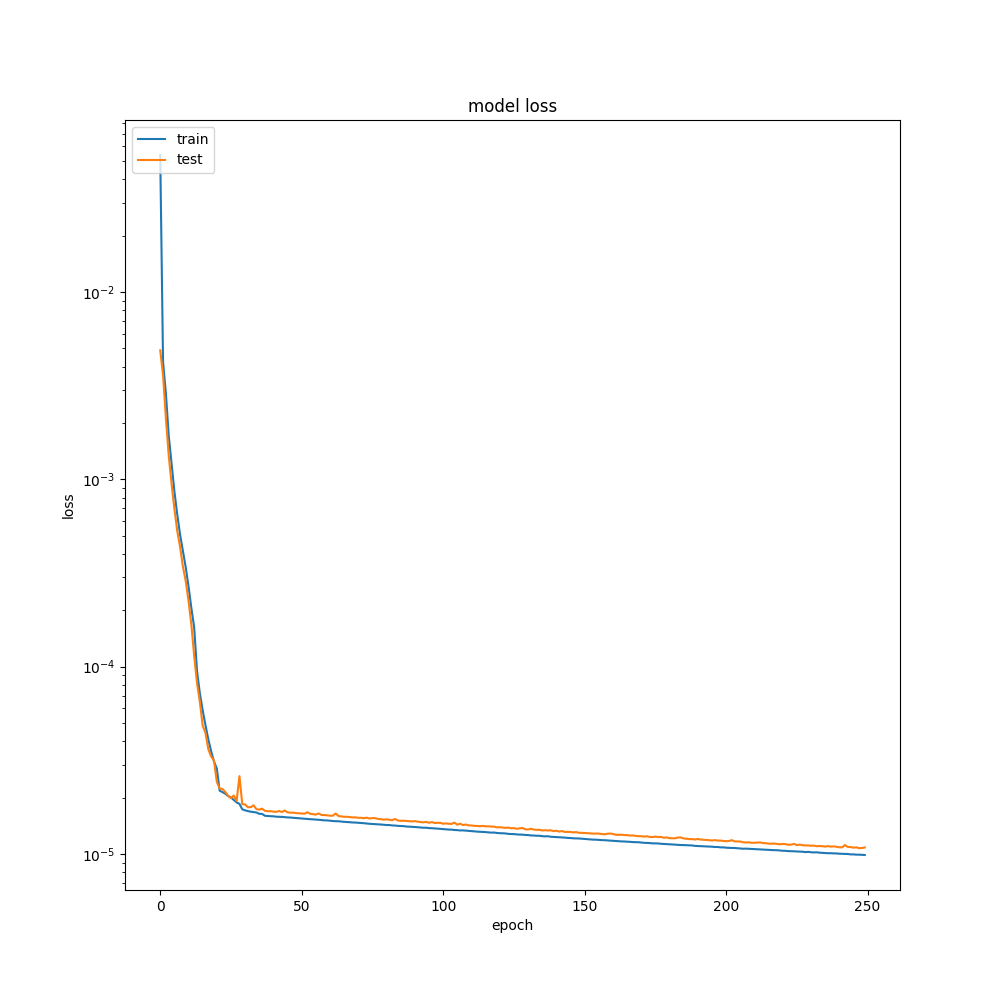

In [9]:
# generated from plot_model_history()
Image(filename='results/lstm_loss.png')

In [10]:
# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4))

# Load the saved model
lstm_model.load_weights('model_weights/lstm_model.h5')

lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=1)

2023-02-27 21:25:48.656294: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 21:25:49.054487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:49.128188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:49.177358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:49.252857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 2s 7ms/step - loss: 2.7220e-05


2.7220150514040142e-05

1/4 [======>.......................] - ETA: 1s

2023-02-27 21:25:54.713594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:54.794091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:54.837046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:25:54.875480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 19ms/step


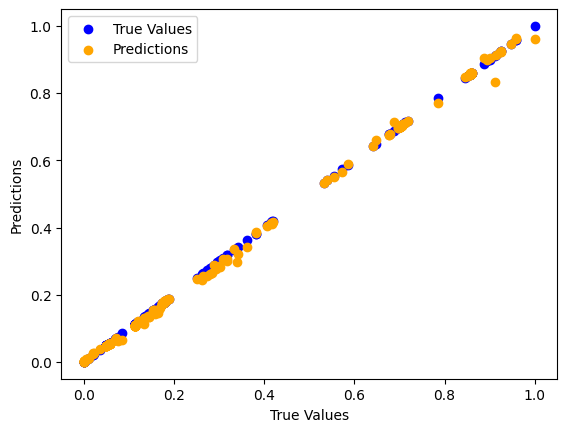

In [11]:
# Get the predicted values for the first 100 points in the test dataset
n = 100
x_sample = x_test_lstm[:n]
y_true = y_test_lstm[:n]
y_pred = lstm_model.predict(x_sample)

# Create a scatter plot comparing the predicted values to the true values
plt.scatter(y_true, y_true, c='blue', label='True Values')
plt.scatter(y_true, y_pred, c='orange', label='Predictions')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

## Transformer Model
The code defines and trains a transformer-based model for a classification task on a given dataset. The dataset is prepared using a function called prepare_data, and the model is defined using the transformer_encoder and build_model functions. The transformer_encoder function implements a multi-head attention mechanism and dense layers for normalization, dropout, and residual connection. The build_model function applies multiple transformer blocks to the input data using the transformer_encoder function, followed by convolutional layers, pooling, and dense layers to generate the output. The model is compiled with the sparse_categorical_crossentropy loss function and the Adam optimizer with a reduced learning rate on plateau. The model is trained for 100 epochs with a batch size of 64 and callbacks for early stopping, checkpointing, and reducing learning rate on plateau. The trained model is evaluated on a test dataset using the evaluate function.

In [12]:
transformer_model = transformer_classifier.build_model(input_shape_transformer,
                                                        num_heads=4,
                                                        num_transformer_blocks=4,
                                                        dropout=0.25)

Uncomment to train transformer

In [13]:
# transformer_classifier.run_model()

In [14]:
transformer_model.load_weights('model_weights/transformer_model.h5')
transformer_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
    metrics="sparse_categorical_accuracy"
)
transformer_model.evaluate(x_test_transformer, y_test_transformer, verbose=1)

2023-02-27 21:26:05.339803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 12s 47ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.7622


[0.659098207950592, 0.7622378468513489]

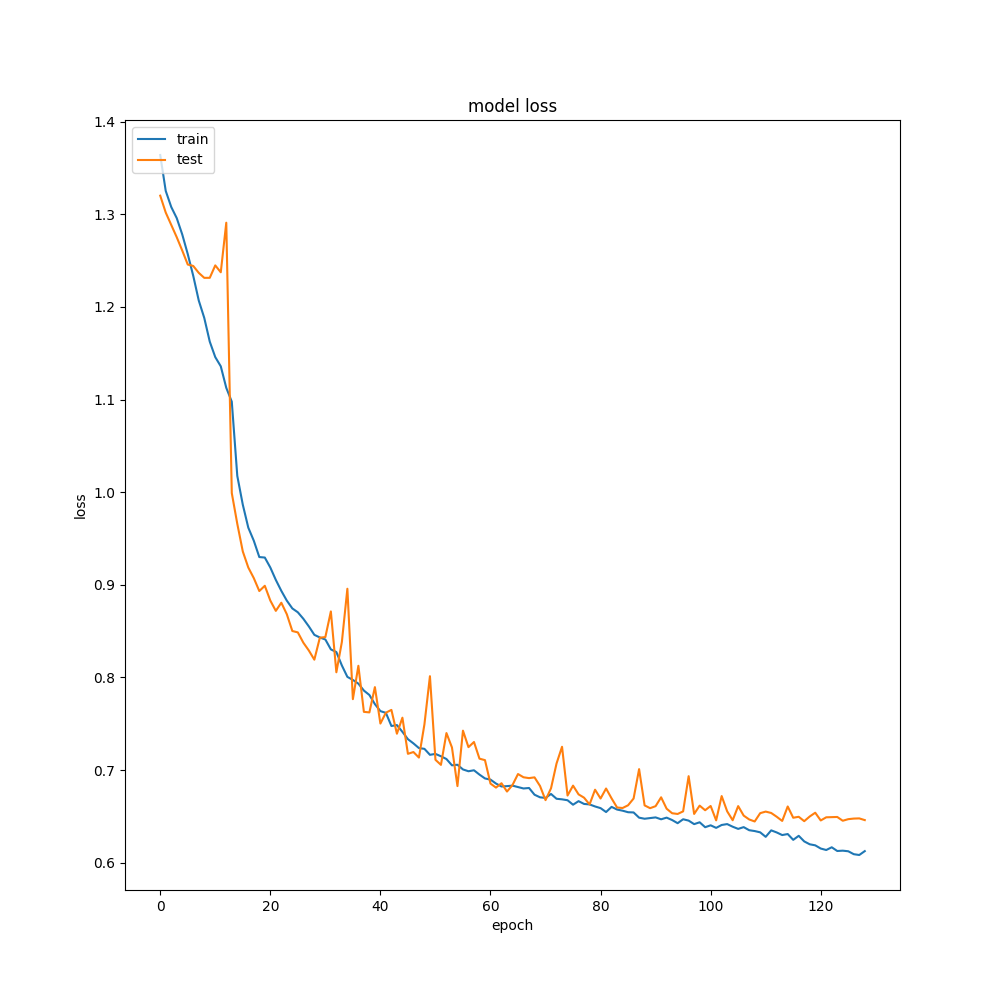

In [15]:
# generated from plot_model_history()
Image(filename='results/transformer_loss.png')

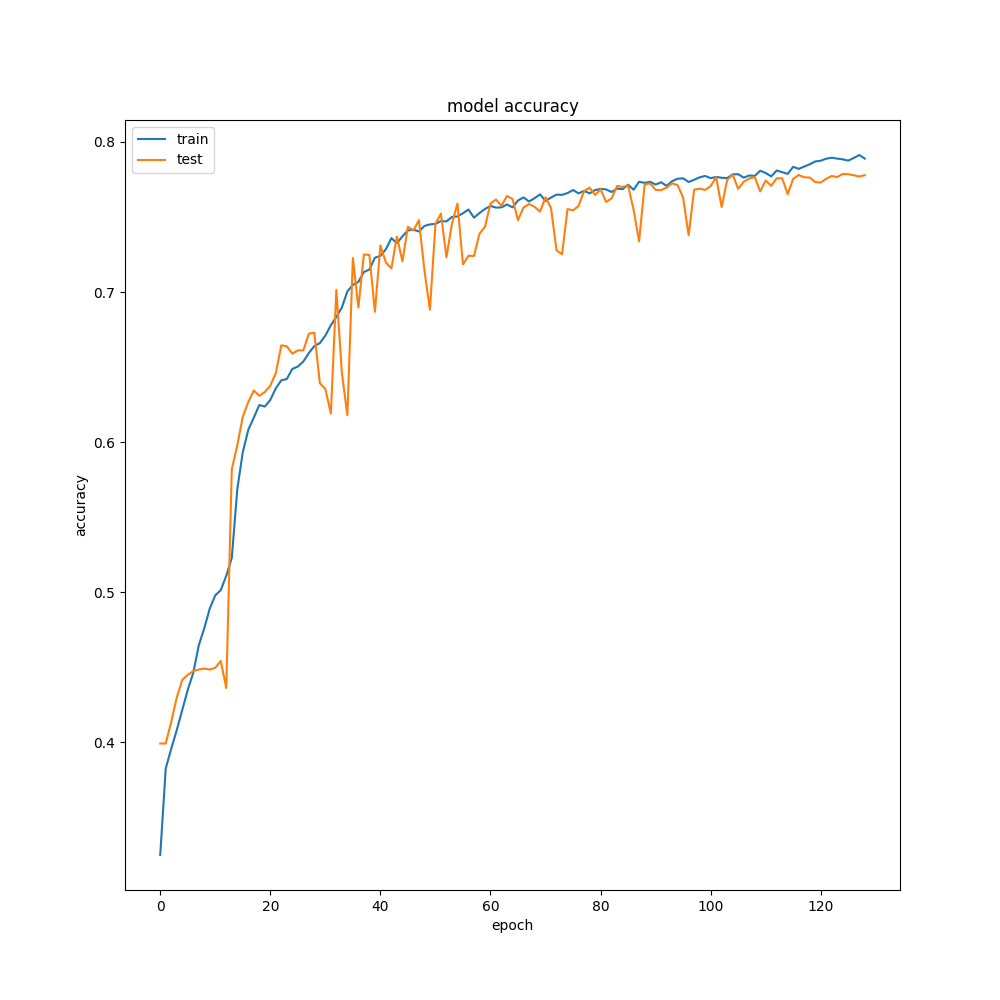

In [16]:
# generated from plot_model_history()
Image(filename='results/transformer_accuracy.png')

Confusion matrix of transformer predictions

2023-02-27 21:26:27.008315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 11s 42ms/step


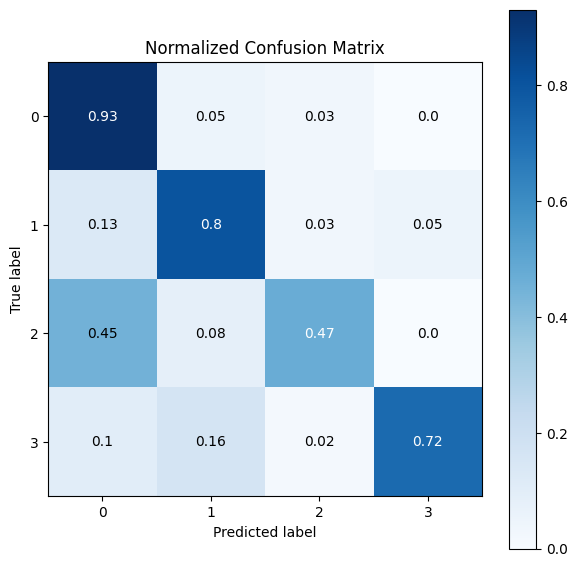

In [17]:
yhat_valid = transformer_model.predict(x_test_transformer)

predicted_classes = np.argmax(yhat_valid, axis=1)

true_classes = y_test_transformer
confuse_fig = scikitplot.metrics.plot_confusion_matrix(
    true_classes,
    predicted_classes,
    normalize='true',
    figsize=(7, 7))
plt.savefig('results/confusion_matrix.png')

## Generate Tableau File
The code prepares data and uses two machine learning models, an LSTM model and a transformer model, using the prepared data. The trained models are used to make predictions on a test set of data. The last location data in each test sequence is replaced with the LSTM model's location prediction. The predictions from the transformer model are converted from integer class values to corresponding transportation modes using a label dictionary. A random sequence of data from the test set is selected, and its columns are transformed to degrees of latitude and longitude. The transformed data is saved to a CSV file named "tableau_data.csv".
Generate Tableau CSV, ready for import into Tableau. Dashboard available [here](https://public.tableau.com/views/AAI530FinalProject-GPSData/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

In [31]:
generate_tableau_csv()

233/233 [==============================] - 2s 7ms/step
